<h1>Custom Image Classification</h1>

In the real world the data we are using will not be nicely formatted as part of a library, it is likely that we will be creating our own datasets. In this example we are exploring a realistic binary classification problem.

Let's explore what its like to work with a more realistic data set. The dataset has been taken from Kaggle and there are 12,500 images of both cats and dogs (this is a large dataset).<br/><br/>
<h2>Visualising Image Data</h2>

In [2]:
# Keras will need to be installed on the first attempt, run this first:
!pip install tensorflow
!pip install pydot

In [4]:
# Import tensorflow and keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")


TensorFlow version: 2.18.0
Keras version: 3.7.0


In [8]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

<h2>Preparing the Data for the model</h2>

There is too much data for us to read all at once in memory. We can use some built in Keras functions to automatically process the data, generate a flow of batches from a directory and manipulate the images.

<b>Image Manipulation</b>

It is standard practice to manipulate the images with rotation, resizing, and scaling so the model becomes more robust to different images that the data set doesn't represent. We can use the **ImageDataGenerator** to do this automatically.

In [11]:
image_gen = ImageDataGenerator(rotation_range=30, # rotate the image 30 degrees
                               width_shift_range=0.1, # Shift the pic width by a max of 10%
                               height_shift_range=0.1, # Shift the pic height by a max of 10%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.2, # Shear means cutting away part of the image (max 20%)
                               zoom_range=0.2, # Zoom in by 20% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

In [13]:
image_gen.flow_from_directory(r'C:\Users\robot\OneDrive - Atlantic TU\CompVis\CA2 Chess\working\chessPieces\train')

Found 486 images belonging to 5 classes.


In [15]:
image_gen.flow_from_directory(r'C:\Users\robot\OneDrive - Atlantic TU\CompVis\CA2 Chess\working\chessPieces\test')

Found 165 images belonging to 5 classes.


<b>Resizing Images</b>

Keras can resize all the images to 150 pixels by 150 pixels once they've been manipulated so they are all a standard size for analysis.

In [18]:
# width,height,channels
image_shape = (150,150,3)

<h2>Building the Model</h2>

In [21]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization

In [23]:
from keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # 5 classes
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,813,381 (64.14 MB)

 Trainable params: 2,098,693 (8.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

<h2>Training the Model</h2>

In [28]:
batch_size = 16

train_image_gen = image_gen.flow_from_directory(r'C:\Users\robot\OneDrive - Atlantic TU\CompVis\CA2 Chess\working\chessPieces\train',
                                               target_size=image_shape[:2],
                                               batch_size=batch_size,
                                               class_mode='categorical')

Found 486 images belonging to 5 classes.


In [30]:
test_image_gen = image_gen.flow_from_directory(r'C:\Users\robot\OneDrive - Atlantic TU\CompVis\CA2 Chess\working\chessPieces\test',
                                               target_size=image_shape[:2],
                                               batch_size=batch_size,
                                               class_mode='categorical')

Found 165 images belonging to 5 classes.


In [32]:
train_image_gen.class_indices

{'bishop': 0, 'knight': 1, 'pawn': 2, 'queen': 3, 'rook': 4}

In [34]:
import warnings
warnings.filterwarnings('ignore')

In [40]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_image_gen.classes),
    y=train_image_gen.classes
)

In [42]:
from keras.callbacks import ReduceLROnPlateau
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, min_lr=0.00001)

In [44]:
# This model with epochs=10 and steps_per_epoch=150
results = model.fit(train_image_gen,epochs=100,
                    steps_per_epoch=200,
                    validation_data=test_image_gen,
                    validation_steps=len(test_image_gen),
                    callbacks=[lr_reduction])


Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 36s 172ms/step - accuracy: 0.4252 - loss: 1.5607 - val_accuracy: 0.5333 - val_loss: 1.1309 - learning_rate: 0.0010
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 34s 165ms/step - accuracy: 0.6248 - loss: 0.9031 - val_accuracy: 0.6424 - val_loss: 0.9765 - learning_rate: 0.0010
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 37s 182ms/step - accuracy: 0.7277 - loss: 0.7380 - val_accuracy: 0.6788 - val_loss: 0.9691 - learning_rate: 0.0010
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 38s 184ms/step - accuracy: 0.7435 - loss: 0.6369 - val_accuracy: 0.6182 - val_loss: 1.0533 - learning_rate: 0.0010
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 43s 211ms/step - accuracy: 0.7745 - loss: 0.5873 - val_accuracy: 0.7212 - val_loss: 0.9749 - learning_rate: 0.0010
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 36s 177ms/step - accuracy: 0.7871 - loss: 0.5584 - val_accuracy: 0.7030 - val_loss: 0.9713 - learning_rate: 0.0010
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 38s 185ms/step - accura

In [46]:
# This saved model can be saved and used later if required, rather than building the model each time.
model.save('chess_piece_classifier100ep-200st.keras')


In [48]:
from sklearn.metrics import confusion_matrix, classification_report


# Predict on validation data
y_pred = np.argmax(model.predict(test_image_gen), axis=1)
y_true = test_image_gen.classes

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(train_image_gen.class_indices.keys())))

11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 702ms/step
Confusion Matrix:
[[ 8  7  2 10  9]
 [10 15  3  7  9]
 [ 7  5  2  2  5]
 [ 5 10  2  8  4]
 [ 9 14  3  4  5]]
Classification Report:
              precision    recall  f1-score   support

      bishop       0.21      0.22      0.21        36
      knight       0.29      0.34      0.32        44
        pawn       0.17      0.10      0.12        21
       queen       0.26      0.28      0.27        29
        rook       0.16      0.14      0.15        35

    accuracy                           0.23       165
   macro avg       0.22      0.22      0.21       165
weighted avg       0.22      0.23      0.22       165



<h2>Measuring the Model Results</h2>

In [50]:
results.history['val_accuracy']

[0.5333333611488342,
 0.6424242258071899,
 0.678787887096405,
 0.6181818246841431,
 0.7212121486663818,
 0.7030302882194519,
 0.6969696879386902,
 0.7030302882194519,
 0.678787887096405,
 0.7151514887809753,
 0.6969696879386902,
 0.7090908885002136,
 0.7090908885002136,
 0.7151514887809753,
 0.7333333492279053,
 0.7333333492279053,
 0.6909090876579285,
 0.7212121486663818,
 0.7272727489471436,
 0.7333333492279053,
 0.739393949508667,
 0.7575757503509521,
 0.739393949508667,
 0.7272727489471436,
 0.7212121486663818,
 0.7515151500701904,
 0.7151514887809753,
 0.739393949508667,
 0.7757575511932373,
 0.7272727489471436,
 0.7333333492279053,
 0.7212121486663818,
 0.7090908885002136,
 0.7090908885002136,
 0.739393949508667,
 0.7515151500701904,
 0.739393949508667,
 0.7030302882194519,
 0.6909090876579285,
 0.7454545497894287,
 0.7272727489471436,
 0.7515151500701904,
 0.7515151500701904,
 0.7696969509124756,
 0.739393949508667,
 0.7333333492279053,
 0.7515151500701904,
 0.7090908885002136,


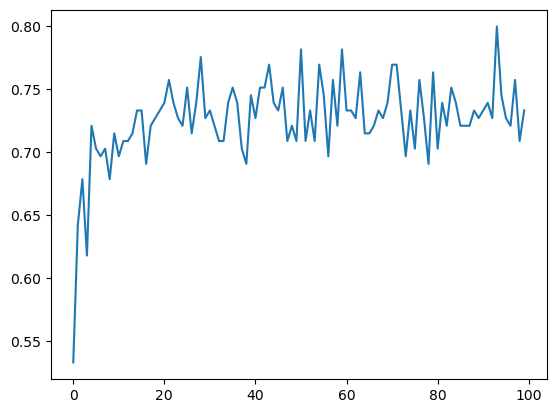

In [52]:
plt.plot(results.history['val_accuracy'])
plt.show()

<h2>Predicting</h2>

In [55]:
train_image_gen.class_indices

{'bishop': 0, 'knight': 1, 'pawn': 2, 'queen': 3, 'rook': 4}

In [57]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

In [59]:
def imageClassification(image):
    # Display the image first
    imageToDisplay = cv2.imread(image)
    imageToDisplay = cv2.cvtColor(imageToDisplay,cv2.COLOR_BGR2RGB)
    plt.imshow(imageToDisplay)

    # Set image up for prediction by model
    imgToClass = load_img(image, target_size=(150, 150))
    imgToClass = img_to_array(imgToClass)
    imgToClass = np.expand_dims(imgToClass, axis=0)
    imgToClass = imgToClass/255
    prediction_probs = model.predict(imgToClass)
    
   # Map class indices to labels (ensure this matches your dataset's classes)
    class_labels = {0: 'Bishop', 1: 'Knight', 2: 'Rook', 3: 'Queen', 4: 'Pawn'}

    # Find the predicted class
    predicted_class_index = np.argmax(prediction_probs[0])  # Get index of highest probability
    predicted_class_label = class_labels[predicted_class_index]
    predicted_probability = prediction_probs[0][predicted_class_index]  # Get the highest probability

    # Create the output label
    label = f"Prediction: {predicted_class_label} ({predicted_probability:.2f})"
    plt.show()
    return label

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


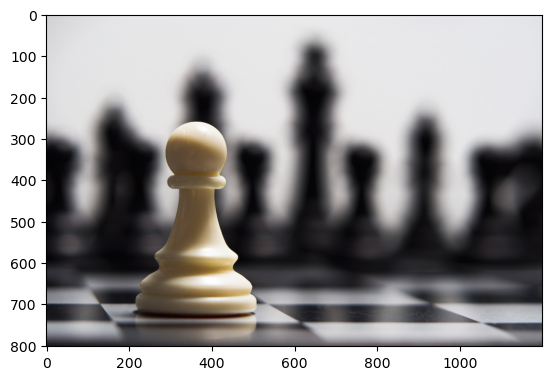

Prediction: Knight (0.84)


In [61]:
print(imageClassification(r"C:\Users\robot\OneDrive - Atlantic TU\CompVis\CA2 Chess\working\pawn.jpeg") )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


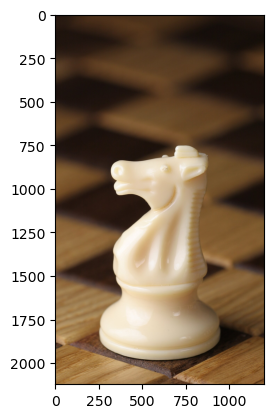

Prediction: Knight (0.52)


In [63]:
print(imageClassification(r"C:\Users\robot\OneDrive - Atlantic TU\CompVis\CA2 Chess\working\White_knight.JPG") )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


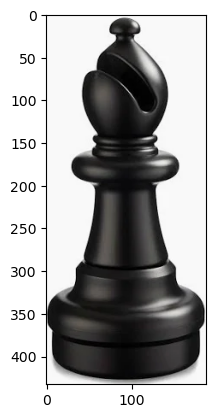

Prediction: Bishop (0.97)


In [65]:
print(imageClassification(r"C:\Users\robot\OneDrive - Atlantic TU\CompVis\CA2 Chess\working\bishop.webp") )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


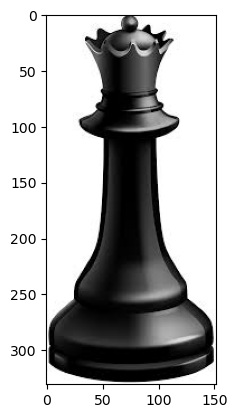

Prediction: Queen (1.00)


In [67]:
print(imageClassification(r"C:\Users\robot\OneDrive - Atlantic TU\CompVis\CA2 Chess\working\queen.jpg") )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


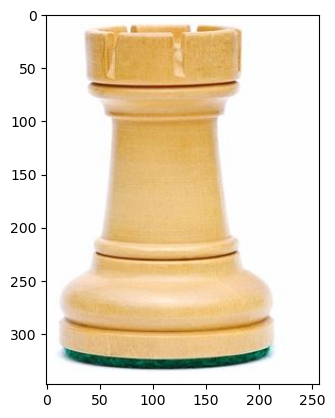

Prediction: Pawn (1.00)


In [69]:
print(imageClassification(r"C:\Users\robot\OneDrive - Atlantic TU\CompVis\CA2 Chess\working\rook.jpg") )

In [237]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Predict on validation data
y_pred = np.argmax(model.predict(test_image_gen), axis=1)
y_true = test_image_gen.classes

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(train_image_gen.class_indices.keys())))

11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step
Confusion Matrix:
[[11 14  3  3  5]
 [13 11  6  8  6]
 [ 5  7  1  2  6]
 [ 8  6  5  7  3]
 [10 10  2  5  8]]
Classification Report:
              precision    recall  f1-score   support

      bishop       0.23      0.31      0.27        36
      knight       0.23      0.25      0.24        44
        pawn       0.06      0.05      0.05        21
       queen       0.28      0.24      0.26        29
        rook       0.29      0.23      0.25        35

    accuracy                           0.23       165
   macro avg       0.22      0.21      0.21       165
weighted avg       0.23      0.23      0.23       165



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


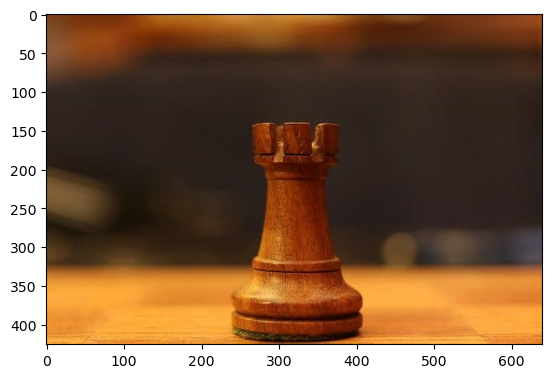

Prediction: Pawn (0.94)


In [71]:
print(imageClassification(r"C:\Users\robot\OneDrive - Atlantic TU\CompVis\CA2 Chess\working\brownrook.jpg") )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


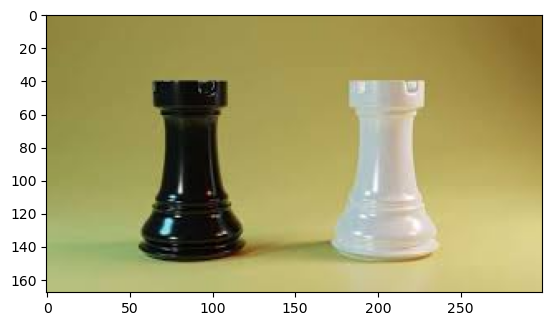

Prediction: Pawn (1.00)


In [73]:
print(imageClassification(r"C:\Users\robot\OneDrive - Atlantic TU\CompVis\CA2 Chess\working\rooks.jpg") )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


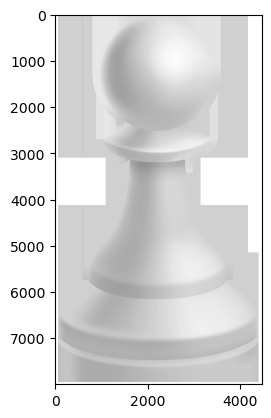

Prediction: Knight (0.32)


In [75]:
print(imageClassification(r"C:\Users\robot\OneDrive - Atlantic TU\CompVis\CA2 Chess\working\whitepawn.png") )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


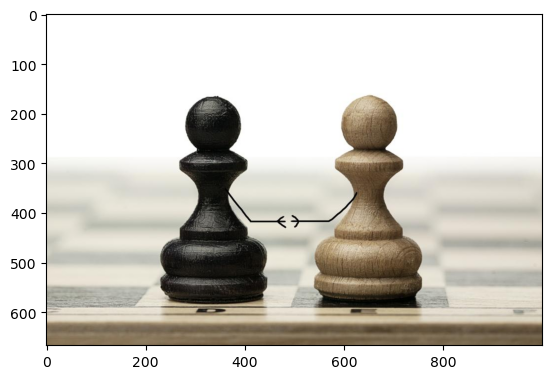

Prediction: Rook (0.97)


In [77]:
print(imageClassification(r"C:\Users\robot\OneDrive - Atlantic TU\CompVis\CA2 Chess\working\pawns.jpeg") )